In [2]:
import pandas as pd
import numpy as np
import h3
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.h3 import ring_buffer_h3_regions_gdf

from charts import plot_learning_curve, plot_fit_time, plot_predict_time, plot_validation_curve, plot_loss_curve


## Read collision data and embedding data

In [3]:
df = pd.read_csv("pedestrian-collisions-final.csv", index_col=0)
df.head()

,Longitude,Latitude,Month,Season,DayofWeek,Workday,Hour,PRECIPITATION,MIN_TEMPERATURE,Target
1320,-113.956380,51.047457,9,Winter,2,Weekday,18,0,-6.6,0
1367,-114.214595,51.147656,12,Summer,1,Weekday,19,0,11.2,0
1050,-114.076599,51.025457,2,Winter,1,Weekday,10,0,-8.6,0
525,-114.106296,51.070546,11,Winter,2,Weekday,14,0,-12.8,1
38,-113.961669,51.125246,9,Summer,6,Weekend,0,1,8.2,0


In [4]:
embeddings = pd.read_csv("geovex_embeddings_5.csv", index_col="region_id")
embeddings.head()

,0,1,2,3,4
region_id,,,,,
8a12ccd49587fff,-32.874290,-54.784424,-78.781680,-43.351560,-54.916782
8a12ea688c77fff,-63.797080,11.184412,-65.254260,-101.014000,-46.922607
8a12ea6c4467fff,-65.608220,-57.550600,-74.741670,-72.391400,-76.290950
8a12ccd0d017fff,-123.948980,-57.499580,-13.267073,-34.239910,70.267210
8a12ccd49637fff,-53.181995,-47.118130,-50.410507,-45.501865,-108.728480


## Get H3 Regions

In [5]:
area_gdf = geocode_to_region_gdf("Calgary, Alberta")

resolution = 10
k_ring_buffer_radius = 4

regionalizer = H3Regionalizer(resolution=resolution)
base_h3_regions = regionalizer.transform(area_gdf)

buffered_h3_regions = ring_buffer_h3_regions_gdf(base_h3_regions, distance=k_ring_buffer_radius)
buffered_h3_geometry = buffered_h3_regions.unary_union

print("Base regions:", len(base_h3_regions))
print("Buffered regions:", len(buffered_h3_regions))

Base regions: 59799
Buffered regions: 65674


### Merge into one dataframe

In [6]:
df["region_id"] = df.apply(lambda x: h3.latlng_to_cell(x["Latitude"],x["Longitude"],10), axis=1)
df.head()

,Longitude,Latitude,Month,Season,DayofWeek,Workday,Hour,PRECIPITATION,MIN_TEMPERATURE,Target,region_id
1320,-113.956380,51.047457,9,Winter,2,Weekday,18,0,-6.6,0,8a12ccd60b5ffff
1367,-114.214595,51.147656,12,Summer,1,Weekday,19,0,11.2,0,8a12ea699a2ffff
1050,-114.076599,51.025457,2,Winter,1,Weekday,10,0,-8.6,0,8a12ccd7284ffff
525,-114.106296,51.070546,11,Winter,2,Weekday,14,0,-12.8,1,8a12ccd29daffff
38,-113.961669,51.125246,9,Summer,6,Weekend,0,1,8.2,0,8a12ea6cc117fff


In [7]:
df_final = pd.merge(df,embeddings, on="region_id")
df_final = df_final.drop(columns=["region_id","Longitude","Latitude"])

target = df_final.pop("Target")
df_final.head()

,Month,Season,DayofWeek,Workday,Hour,PRECIPITATION,MIN_TEMPERATURE,0,1,2,3,4
0,9,Winter,2,Weekday,18,0,-6.6,-172.17163,-44.628890,-43.064323,5.120374,34.184547
1,12,Summer,1,Weekday,19,0,11.2,-120.77812,-97.657326,-30.985016,-54.129620,-11.501679
2,2,Winter,1,Weekday,10,0,-8.6,-139.69052,-66.693985,-61.530453,36.669163,75.037070
3,11,Winter,2,Weekday,14,0,-12.8,-110.10504,-48.948326,10.463181,-58.557407,73.112400
4,1,Winter,5,Weekday,14,1,-7.6,-110.10504,-48.948326,10.463181,-58.557407,73.112400


## Feature Pre-processing

In [8]:
# Cyclical feature transformation
# https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [9]:
ct = ColumnTransformer(
    [
        ("month_sin", sin_transformer(12), ["Month"]),
        ("month_cos", cos_transformer(12), ["Month"]),
        ("weekday_sin", sin_transformer(7), ["DayofWeek"]),
        ("weekday_cos", cos_transformer(7), ["DayofWeek"]),
        ("hour_sin", sin_transformer(24), ["Hour"]),
        ("hour_cos", cos_transformer(24), ["Hour"]),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["Season","Workday"]),
        ("temp", "drop", ["MIN_TEMPERATURE","PRECIPITATION"]),
    ],
    remainder=MinMaxScaler()
).set_output(transform="pandas")

output = ct.fit_transform(df_final)
output.columns

/Users/saadiqmohiuddin/.pyenv/versions/3.10.8/envs/srai/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Index(['month_sin__Month', 'month_cos__Month', 'weekday_sin__DayofWeek',
       'weekday_cos__DayofWeek', 'hour_sin__Hour', 'hour_cos__Hour',
       'cat__Season_Summer', 'cat__Season_Winter', 'cat__Workday_Weekday',
       'cat__Workday_Weekend', 'remainder__0', 'remainder__1', 'remainder__2',
       'remainder__3', 'remainder__4'],
      dtype='object')

In [10]:
X = output.to_numpy()
y = target

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)
X_train.shape

(2835, 15)

## Train Linear Classifier

In [12]:
random_state = 1
num_folds = 5
acc_metric="accuracy"
acc_label="Accuracy"

### Validation Curves

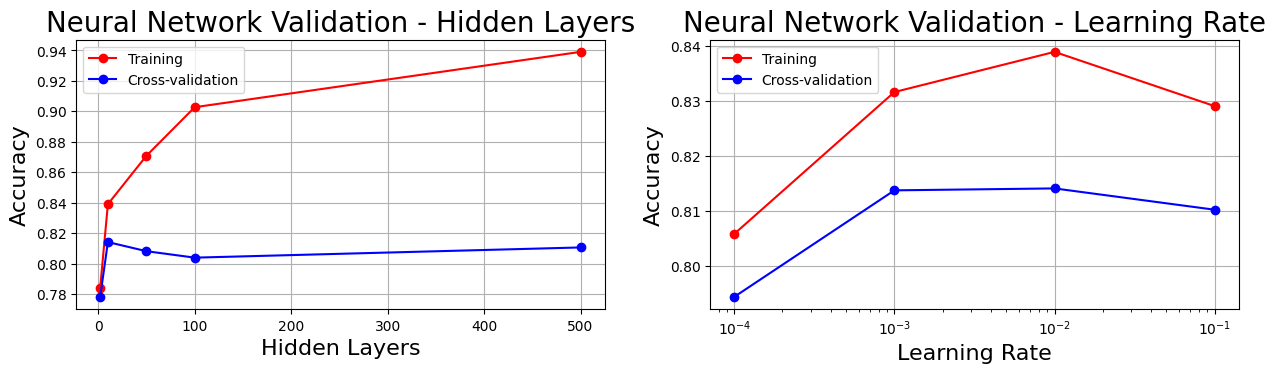

In [107]:
fig, axes = plt.subplots(1,2, figsize=(15, 3.5),squeeze=False)


# Hidden Layers/Depth
max_depth_values = [2, 10, 50 ,100, 500]

train_scores_depth, valid_scores_depth = validation_curve(
    MLPClassifier(solver='adam',random_state=random_state, learning_rate_init=0.01, max_iter=2000), 
    X=X_train, 
    y=y_train, 
    param_name="hidden_layer_sizes", 
    param_range=max_depth_values,
    cv=num_folds,
    scoring=acc_metric
)

# Learning Rate
learn_rates= [0.0001,0.001,0.01,0.1]

train_scores_learning, valid_scores_learning = validation_curve(
    MLPClassifier(solver='adam', hidden_layer_sizes=10, random_state=random_state,max_iter=2000), 
    X=X_train, 
    y=y_train, 
    param_name="learning_rate_init", 
    param_range=learn_rates,
    cv=num_folds,
    scoring=acc_metric
)

plot_validation_curve(
    train_scores_depth,
    valid_scores_depth,
    max_depth_values,
    "Neural Network Validation - Hidden Layers",
    acc_label,
    "Hidden Layers",
    axes=axes[0,0],
)

plot_validation_curve(
    train_scores_learning,
    valid_scores_learning,
    learn_rates,
    "Neural Network Validation - Learning Rate",
    acc_label,
    "Learning Rate",
    axes=axes[0,1],
    x_log=True
)

### Learning Curves

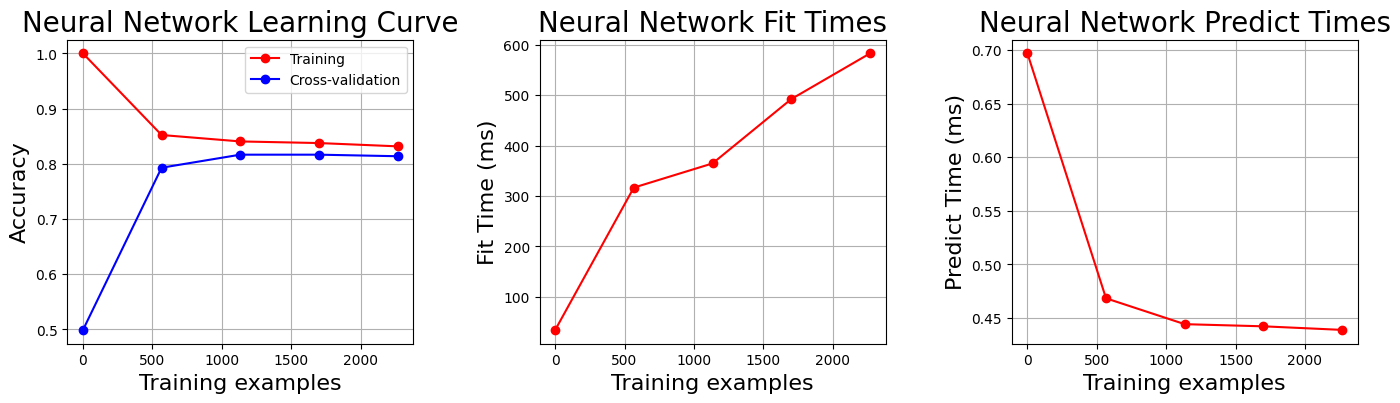

In [109]:
sizes = np.linspace(1, len(X_train)-len(X_train)/num_folds, 5,dtype=int)
fig, axes = plt.subplots(1, 3, figsize=(15, 5),squeeze=False)
fig.tight_layout(pad=6.0)

train_sizes, train_scores, validation_scores, fit_times, predict_times = learning_curve(
    estimator = MLPClassifier(
        solver='adam', 
        activation="relu", 
        hidden_layer_sizes=10, 
        random_state=1, 
        learning_rate_init=0.001,
        max_iter=10000),
    X = X_train,
    y = y_train,
    train_sizes=sizes,
    scoring = acc_metric,
    cv=5,
    random_state=1,
    return_times=True
)

plot_learning_curve(
    train_scores,
    validation_scores,
    train_sizes,
    title="Neural Network Learning Curve",
    y_axis=acc_label,
    axes=axes[0,0]
)

plot_fit_time(
    fit_times,
    train_sizes,
    title="Neural Network Fit Times",
    y_axis="Fit Time (s)",
    axes=axes[0,1]
)

plot_predict_time(
    predict_times,
    train_sizes,
    title="Neural Network Predict Times",
    y_axis="Predict Time (s)",
    axes=axes[0,2]
)


### Loss Curve

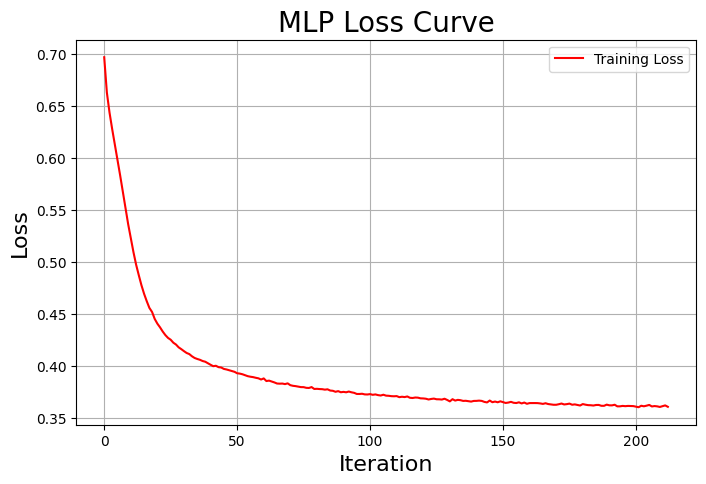

In [112]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5),squeeze=False)

mlp = MLPClassifier(
    solver='adam', 
    hidden_layer_sizes=10, 
    random_state=random_state, 
    learning_rate_init=0.001,
    max_iter=5000,
    n_iter_no_change=10,
    batch_size = 32
)
mlp.fit(X_train, y_train)

plot_loss_curve(
    mlp.loss_curve_,
    title="MLP Loss Curve",
    y_axis="Loss",
    x_axis="Iteration",
    axes=axes[0,0]
)

## Train MLP

In [13]:
clf = MLPClassifier(
    solver='adam', 
    activation="relu", 
    hidden_layer_sizes=(10), 
    random_state=1,
    learning_rate_init=0.001,
    max_iter=5000,
).fit(X_train, y_train)
clf.score(X_test, y_test)

0.84

## Prediction & Visualization

In [14]:
from palettable.scientific.sequential import LaPaz_10
from lonboard.colormap import apply_continuous_cmap
from lonboard import Map, SolidPolygonLayer
from lonboard.basemap import CartoBasemap

In [18]:
def collision_prediction(
    embeddings,
    buffered_h3_regions,
    hour,
    dayofweek,
    month,
):

    winter_months = [1,2,3,4,10,11,12]
    
    if month in winter_months:
        season="Winter"
    else:
        season="Summer"

    workdays = [0,1,2,3,4]

    if dayofweek in workdays:
        workday="Weekday"
    else:
        workday="Weekend"

    # predict across all h3 regions
    print(hour,dayofweek, month, season, workday) 
    prediction = embeddings.assign(
        Hour=hour, 
        DayofWeek=dayofweek,
        Month=month,
        Season=season,
        Workday=workday,
    )
    
    # transform input
    input = ct.transform(prediction)
    
    preds = clf.predict_proba(input.to_numpy())
    preds = preds[:,1]
    preds = np.where(preds > 0.6, preds, 0)
    
    prediction["prediction"] = preds

    prediction = prediction[prediction["prediction"]>0]
    nbins=10
    est = KBinsDiscretizer(n_bins=nbins, encode='ordinal')
    prediction["color"] = est.fit_transform(prediction["prediction"].to_numpy().reshape(-1, 1))/nbins

    df = pd.merge(buffered_h3_regions, prediction, on=["region_id"])[['color','prediction','geometry']]

    layer = SolidPolygonLayer.from_geopandas(
        df,
        get_fill_color=apply_continuous_cmap(df["color"], LaPaz_10),
        opacity=0.7
    )
    
    map_ = Map(
        layers=[layer],
        basemap_style=CartoBasemap.DarkMatter,
        _height=1000,
        _initial_view_state={
            "zoom":10, 
            "latitude":51.05009, 
            "longitude":-114.06984
        })
    
    return map_

In [19]:
collision_prediction(
    embeddings,
    buffered_h3_regions,
    hour=9,
    dayofweek=5,
    month=12
)

9 5 12 Winter Weekend


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…